# **Unsmoothing of linear time series**

Let's first import different dependencies and the data:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns

In [12]:
alternative_data_raw = pd.read_excel('EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)
alternative_data_raw.tail(10)

Commodity - USD Unhedged  ...  UK Property Direct - USD Unhedged
QUARTER                            ...                                   
2021-Q2                  201.8662  ...                         278.205508
2021-Q3                  215.1673  ...                         280.913387
2021-Q4                  211.8033  ...                         305.081135
2022-Q1                  265.9137  ...                         290.587837
2022-Q2                  250.8549  ...                         236.794741
2022-Q3                  240.5519  ...                         187.833995
2022-Q4                  245.8892  ...                         210.098219
2023-Q1                  232.7065  ...                         214.263907
2023-Q2                  226.7436  ...                         211.147599
2023-Q3                  235.6700  ...                         224.439503

[10 rows x 9 columns]

# **I. Data Analysis**
## Preprocessing

In [13]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

/tmp/ipykernel_156300/1780709471.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime


Commodity_-_USD_Unhedged  ...  UK_Property_Direct_-_USD_Unhedged_%
QUARTER                               ...                                     
2021-04-01                  201.8662  ...                             0.056565
2021-07-01                  215.1673  ...                             0.009733
2021-10-01                  211.8033  ...                             0.086033
2022-01-01                  265.9137  ...                            -0.047506
2022-04-01                  250.8549  ...                            -0.185118
2022-07-01                  240.5519  ...                            -0.206764
2022-10-01                  245.8892  ...                             0.118531
2023-01-01                  232.7065  ...                             0.019827
2023-04-01                  226.7436  ...                            -0.014544
2023-07-01                  235.6700  ...                             0.062951

[10 rows x 18 columns]

##  Data Visualisation

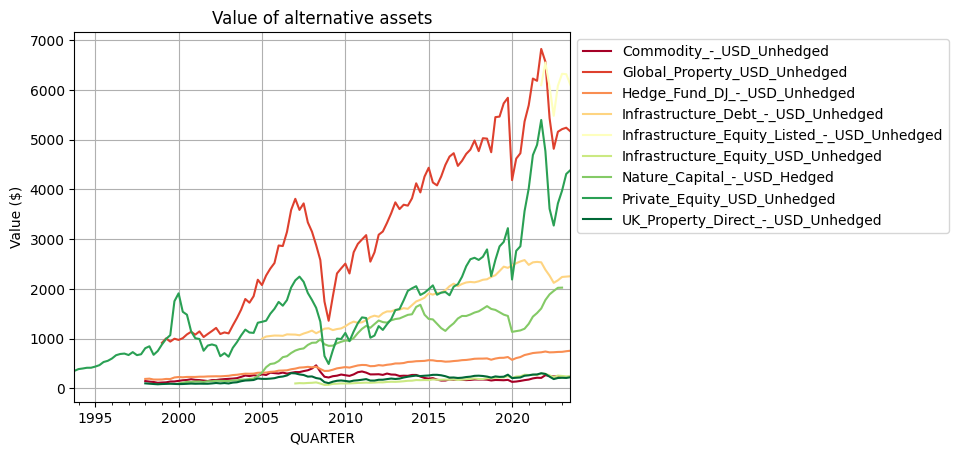

In [14]:
(alternative_data.iloc[:,0:9]
.plot(cmap = 'RdYlGn',grid=True,ylabel='Value ($)', title='Value of alternative assets')
.legend(bbox_to_anchor = (1,1)))

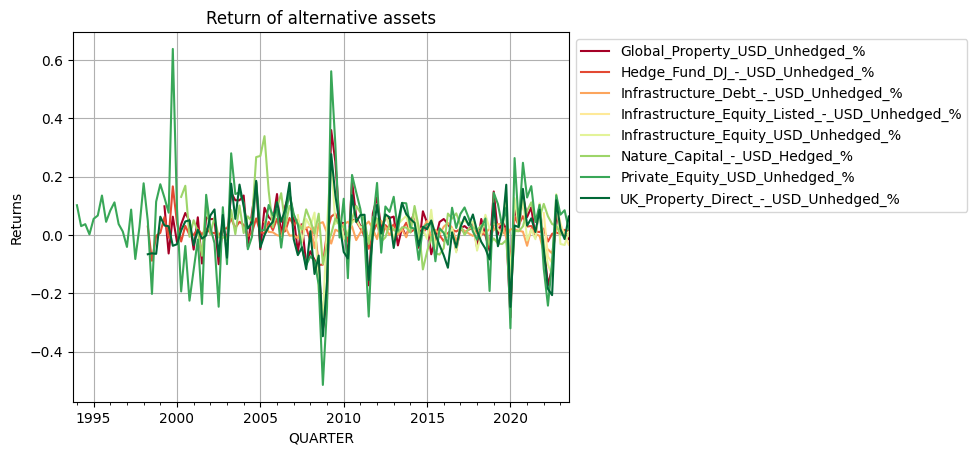

In [15]:
(alternative_data.iloc[:,10:]
.plot(cmap = 'RdYlGn',grid=True,ylabel='Returns', title='Return of alternative assets')
.legend(bbox_to_anchor = (1,1)))

##  Stationarity analysis 

In [16]:
unit_test = {name: (adfuller(alternative_data[name].dropna())[0], adfuller(alternative_data[name].dropna())[1]) 
       for name in alternative_data.iloc[:,10:].columns}

(pd.DataFrame(unit_test, index = ['value','p-value']).T.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn'))

/home/perann/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/perann/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/perann/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


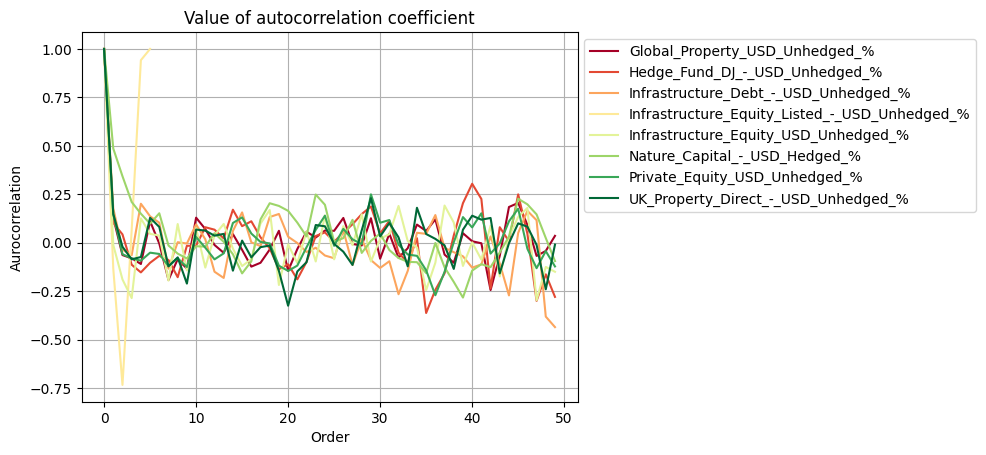

In [17]:
serial_correlation = pd.DataFrame({name:  [alternative_data[name].dropna().autocorr(k) for k in range (50)]
                       for name in alternative_data.iloc[:,10:].columns})

(serial_correlation
.plot(grid = True, cmap  = 'RdYlGn', xlabel='Order', ylabel ='Aurocorrelation', title = 'Value of autocorrelation coefficient' )
.legend(bbox_to_anchor = (1,1)))

##  Methode linéaire d'interpolation

In [18]:
linear_interpolation = alternative_data.iloc[:,0:9].resample('MS').interpolate().pct_change()

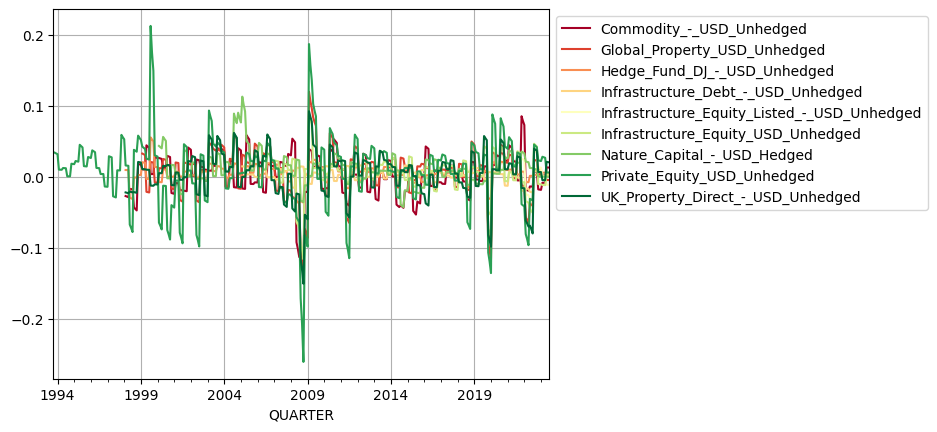

In [19]:
linear_interpolation.plot(grid = True, cmap = 'RdYlGn').legend(bbox_to_anchor = (1,1))

In [20]:
def cumulated_returns(serie):
    return (1 + serie).cumprod() - 1

In [21]:
linear_interpolation.agg(cumulated_returns)

Commodity_-_USD_Unhedged  ...  UK_Property_Direct_-_USD_Unhedged
QUARTER                               ...                                   
1993-10-01                       NaN  ...                                NaN
1993-11-01                       NaN  ...                                NaN
1993-12-01                       NaN  ...                                NaN
1994-01-01                       NaN  ...                                NaN
1994-02-01                       NaN  ...                                NaN
...                              ...  ...                                ...
2023-03-01                  0.536068  ...                           1.081570
2023-04-01                  0.522720  ...                           1.071379
2023-05-01                  0.542702  ...                           1.114844
2023-06-01                  0.562684  ...                           1.158309
2023-07-01                  0.582666  ...                           1.201774

[358 rows x 9 columns]

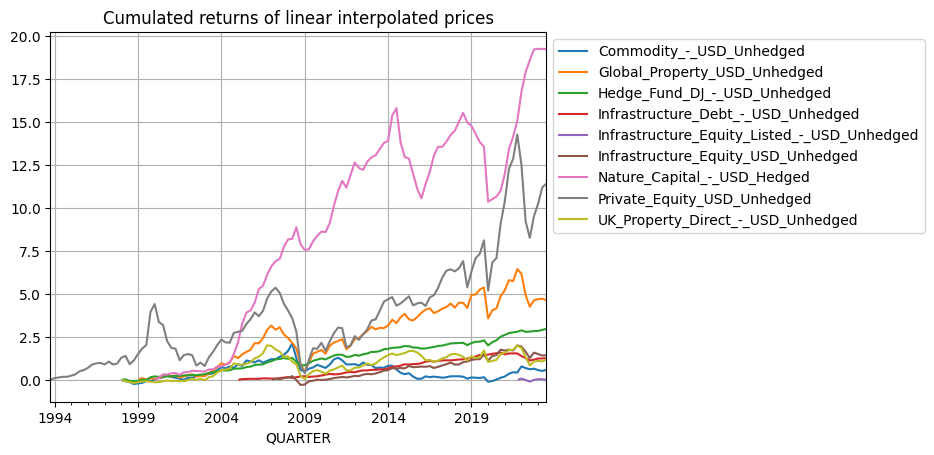

In [22]:
linear_interpolation.agg(cumulated_returns).plot(grid = True, title = 'Cumulated returns of linear interpolated prices').legend(bbox_to_anchor = (1,1))

### Correlation matrix

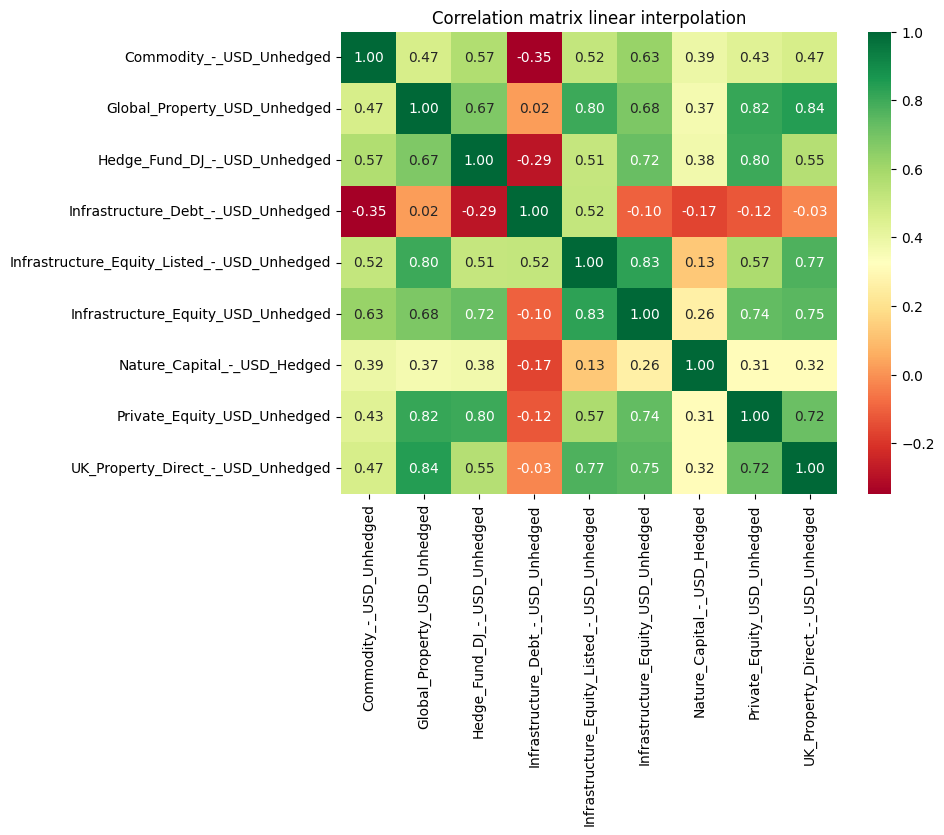

In [23]:
plt.figure(figsize=(8, 6))
corr_matrix  = linear_interpolation.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix linear interpolation')
plt.show()

# **II. Autoregressive method**
##  Unsmoothing series

In [24]:
from AR_Model.AR_functions import AR_model

In [25]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed= data_unsmoothing(alternative_data.iloc[:,0:9])
#unsmoothed = data_unsmoothing(alternative_data.iloc[:,9:], interpolate= False)

/tmp/ipykernel_156300/2814987358.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  new = df_.resample('MS').interpolate(method='polynomial', order = 2).pct_change()
/home/perann/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
from AR_Model.AR_rebase import AR_rebase

def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


ModuleNotFoundError: No module named 'AR_Model.AR_rebase'

## Results visualisation

### Cumulated returns:

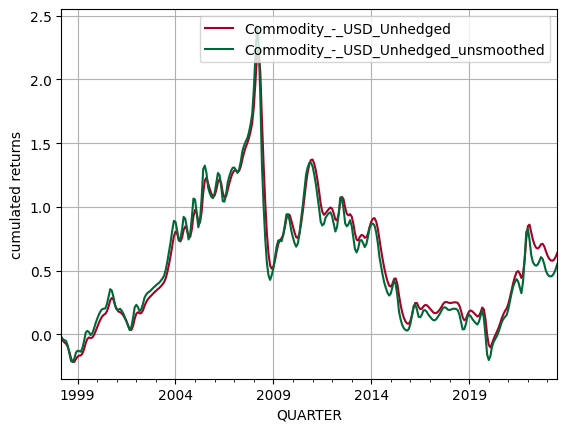

In [16]:
(unsmoothed.iloc[:,[0,9]].dropna().agg(cumulated_returns)
.plot(grid = True, cmap = 'RdYlGn',ylabel='cumulated returns')
.legend())

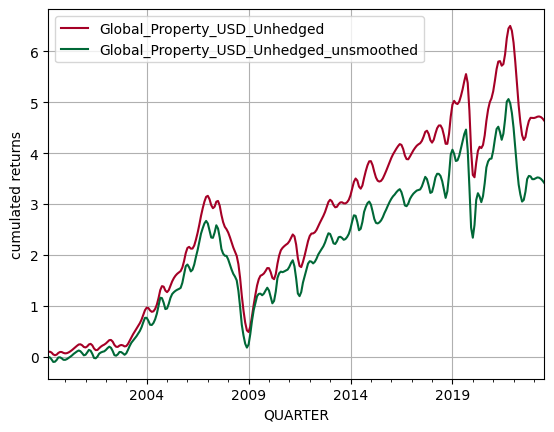

In [17]:
(unsmoothed.iloc[:,[1,10]].agg(cumulated_returns).dropna()
.plot(grid = True, cmap = 'RdYlGn',ylabel='cumulated returns')
.legend())


### Interpolation:

Text(0.5, 1.0, 'Year 2018 interpolation')

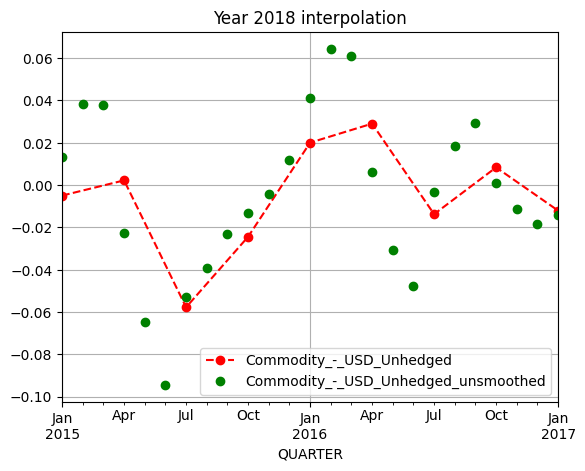

In [18]:
fig, axis = plt.subplots()
(unsmoothed.loc['2015-01-01':'2017-01-01', unsmoothed.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

axis.set_title('Year 2018 interpolation')

###  Serial correlation:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


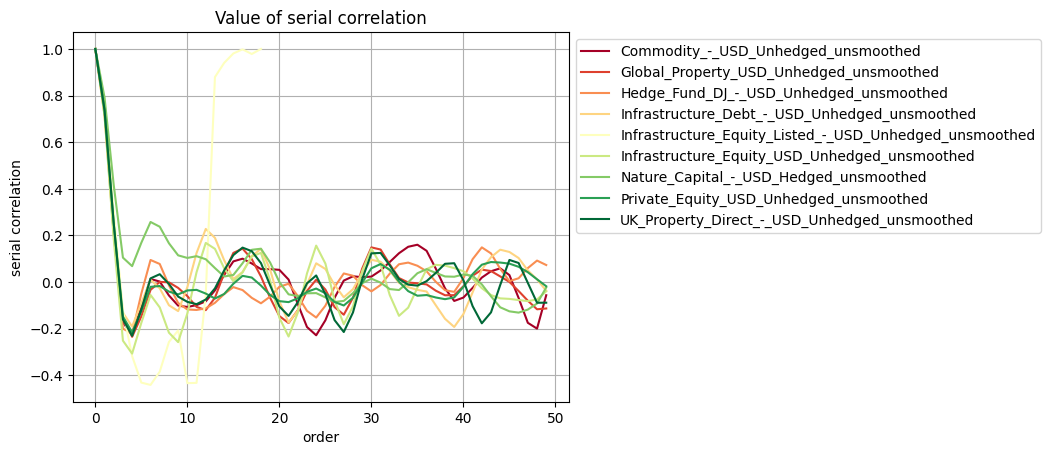

In [19]:
serial_correlation_unsmoothed = pd.DataFrame({name:[unsmoothed[name].dropna().autocorr(k) for k in range (50)]
for name in unsmoothed.iloc[:,9:].columns})

(serial_correlation_unsmoothed
.plot(grid = True, cmap  = 'RdYlGn', xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

In [20]:
unsmoothed.tail()

Commodity_-_USD_Unhedged  Global_Property_USD_Unhedged  \
QUARTER                                                              
2023-03-01                 -0.008515                      0.002796   
2023-04-01                 -0.002190                      0.000886   
2023-05-01                  0.005427                     -0.001896   
2023-06-01                  0.013339                     -0.004813   
2023-07-01                  0.020150                     -0.007452   

            Hedge_Fund_DJ_-_USD_Unhedged  Infrastructure_Debt_-_USD_Unhedged  \
QUARTER                                                                        
2023-03-01                      0.006081                           -0.000050   
2023-04-01                      0.006231                           -0.000054   
2023-05-01                      0.005140                            0.000472   
2023-06-01                      0.004408                            0.001030   
2023-07-01                      0.003403                            0.001519   

            Infrastructure_Equity_Listed_-_USD_Unhedged  \
QUARTER                                                   
2023-03-01                                    -0.000171   
2023-04-01                                    -0.003808   
2023-05-01                                    -0.007432   
2023-06-01                                    -0.011622   
2023-07-01                                    -0.015184   

            Infrastructure_Equity_USD_Unhedged  Nature_Capital_-_USD_Hedged  \
QUARTER                                                                       
2023-03-01                           -0.011284                          0.0   
2023-04-01                           -0.007577                          0.0   
2023-05-01                           -0.002151                          0.0   
2023-06-01                            0.003196                          0.0   
2023-07-01                            0.008315                          0.0   

            Private_Equity_USD_Unhedged  UK_Property_Direct_-_USD_Unhedged  \
QUARTER                                                                      
2023-03-01                     0.029192                          -0.007769   
2023-04-01                     0.024421                           0.000056   
2023-05-01                     0.014499                           0.010404   
2023-06-01                     0.006039                           0.021224   
2023-07-01                    -0.002589                           0.030142   

            Commodity_-_USD_Unhedged_unsmoothed  \
QUARTER                                           
2023-03-01                            -0.001930   
2023-04-01                             0.004135   
2023-05-01                             0.013044   
2023-06-01                             0.021250   
2023-07-01                             0.026961   

            Global_Property_USD_Unhedged_unsmoothed  \
QUARTER                                               
2023-03-01                                 0.003854   
2023-04-01                                -0.001023   
2023-05-01                                -0.004678   
2023-06-01                                -0.007730   
2023-07-01                                -0.010091   

            Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed  \
QUARTER                                               
2023-03-01                                 0.007506   
2023-04-01                                 0.006380   
2023-05-01                                 0.004050   
2023-06-01                                 0.003676   
2023-07-01                                 0.002398   

            Infrastructure_Debt_-_USD_Unhedged_unsmoothed  \
QUARTER                                                     
2023-03-01                                      -0.003416   
2023-04-01                                      -0.000058   
2023-05-01                                       0.000999   
2023-06-01

### Volatility:

In [21]:
import numpy as np

def volatility_from_month(x):
    return np.sqrt(12)*x.std()

<Axes: xlabel='QUARTER'>

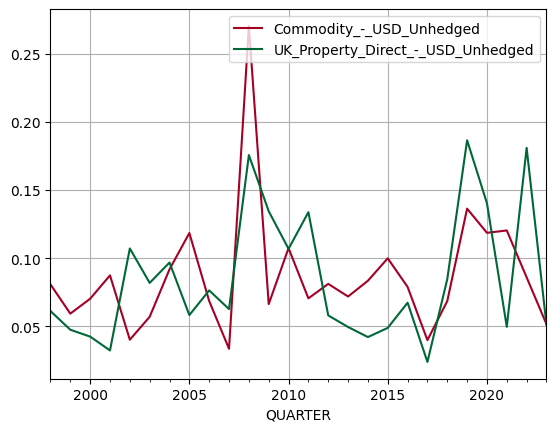

In [22]:
(unsmoothed.iloc[:,[0,8]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'RdYlGn'))

In [23]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" not in col]].resample('YS')
.agg(volatility_from_month)
.dropna())

Commodity_-_USD_Unhedged  Global_Property_USD_Unhedged  \
QUARTER                                                              
2021-01-01                  0.120338                      0.066011   
2022-01-01                  0.085977                      0.125381   
2023-01-01                  0.051643                      0.012835   

            Hedge_Fund_DJ_-_USD_Unhedged  Infrastructure_Debt_-_USD_Unhedged  \
QUARTER                                                                        
2021-01-01                      0.011390                            0.033327   
2022-01-01                      0.016277                            0.054535   
2023-01-01                      0.005146                            0.009331   

            Infrastructure_Equity_Listed_-_USD_Unhedged  \
QUARTER                                                   
2021-01-01                                     0.052301   
2022-01-01                                     0.108477   
2023-01-01                                     0.026608   

            Infrastructure_Equity_USD_Unhedged  Nature_Capital_-_USD_Hedged  \
QUARTER                                                                       
2021-01-01                            0.063719                     0.032950   
2022-01-01                            0.138481                     0.030936   
2023-01-01                            0.035725                     0.004320   

            Private_Equity_USD_Unhedged  UK_Property_Direct_-_USD_Unhedged  
QUARTER                                                                     
2021-01-01                     0.104514                           0.049707  
2022-01-01                     0.193709                           0.180848  
2023-01-01                     0.041631                           0.051261

<Axes: xlabel='QUARTER'>

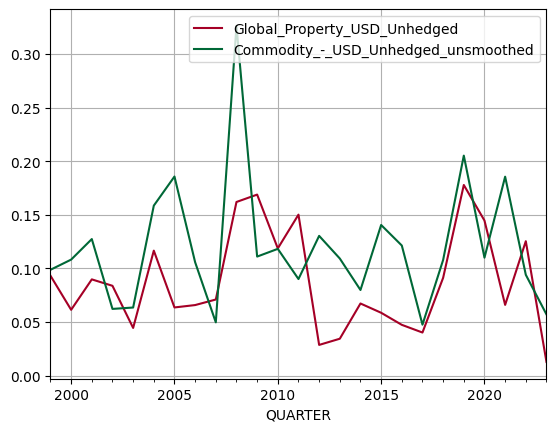

In [24]:
(unsmoothed.iloc[:,[1,9]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'RdYlGn'))

In [25]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]]
.dropna()
.resample('YS')
.agg(volatility_from_month))

Commodity_-_USD_Unhedged_unsmoothed  \
QUARTER                                           
2021-01-01                                  NaN   
2022-01-01                             0.094057   
2023-01-01                             0.057137   

            Global_Property_USD_Unhedged_unsmoothed  \
QUARTER                                               
2021-01-01                                      NaN   
2022-01-01                                 0.155430   
2023-01-01                                 0.018789   

            Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed  \
QUARTER                                               
2021-01-01                                      NaN   
2022-01-01                                 0.024104   
2023-01-01                                 0.006862   

            Infrastructure_Debt_-_USD_Unhedged_unsmoothed  \
QUARTER                                                     
2021-01-01                                            NaN   
2022-01-01                                       0.065660   
2023-01-01                                       0.008225   

            Infrastructure_Equity_Listed_-_USD_Unhedged_unsmoothed  \
QUARTER                                                              
2021-01-01                                                NaN        
2022-01-01                                           0.144131        
2023-01-01                                           0.027049        

            Infrastructure_Equity_USD_Unhedged_unsmoothed  \
QUARTER                                                     
2021-01-01                                            NaN   
2022-01-01                                       0.196346   
2023-01-01                                       0.042116   

            Nature_Capital_-_USD_Hedged_unsmoothed  \
QUARTER                                              
2021-01-01                                     NaN   
2022-01-01                                0.029231   
2023-01-01                                0.010871   

            Private_Equity_USD_Unhedged_unsmoothed  \
QUARTER                                              
2021-01-01                                     NaN   
2022-01-01                                0.225027   
2023-01-01                                0.061355   

            UK_Property_Direct_-_USD_Unhedged_unsmoothed  
QUARTER                                                   
2021-01-01                                           NaN  
2022-01-01                                      0.235082  
2023-01-01                                      0.071668

In [26]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" not in col]].resample('YS')
.agg(volatility_from_month)
.dropna()) - (unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].resample('YS')
.agg(volatility_from_month)
.dropna()) >= 0

Commodity_-_USD_Unhedged  Commodity_-_USD_Unhedged_unsmoothed  \
QUARTER                                                                     
2021-01-01                     False                                False   
2022-01-01                     False                                False   
2023-01-01                     False                                False   

            Global_Property_USD_Unhedged  \
QUARTER                                    
2021-01-01                         False   
2022-01-01                         False   
2023-01-01                         False   

            Global_Property_USD_Unhedged_unsmoothed  \
QUARTER                                               
2021-01-01                                    False   
2022-01-01                                    False   
2023-01-01                                    False   

            Hedge_Fund_DJ_-_USD_Unhedged  \
QUARTER                                    
2021-01-01                         False   
2022-01-01                         False   
2023-01-01                         False   

            Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed  \
QUARTER                                               
2021-01-01                                    False   
2022-01-01                                    False   
2023-01-01                                    False   

            Infrastructure_Debt_-_USD_Unhedged  \
QUARTER                                          
2021-01-01                               False   
2022-01-01                               False   
2023-01-01                               False   

            Infrastructure_Debt_-_USD_Unhedged_unsmoothed  \
QUARTER                                                     
2021-01-01                                          False   
2022-01-01                                          False   
2023-01-01                                          False   

            Infrastructure_Equity_Listed_-_USD_Unhedged  \
QUARTER                                                   
2021-01-01                                        False   
2022-01-01                                        False   
2023-01-01                                        False   

            Infrastructure_Equity_Listed_-_USD_Unhedged_unsmoothed  \
QUARTER                                                              
2021-01-01                                              False        
2022-01-01                                              False        
2023-01-01                                              False        

            Infrastructure_Equity_USD_Unhedged  \
QUARTER                                          
2021-01-01                               False   
2022-01-01                               False   
2023-01-01                               False   

            Infrastructure_Equity_USD_Unhedged_unsmoothed  \
QUARTER                                                     
2021-01-01                                          False   
2022-01-01                                          False   
2023-01-01                                          False   

            Nature_Capital_-_USD_Hedged  \
QUARTER                                   
2021-01-01                        False   
2022-01-01                        False   
2023-01-01                        False   

            Nature_Capital_-_USD_Hedged_unsmoothed  \
QUARTER                                              
2021-01-01                                   False   
2022-01-01                                   False   
2023-01-01                                   False   

            Private_Equity_USD_Unhedged  \
QUARTER                                   
2021-01-01                        False   
2022-01-01                        False   
2023-01-01                        False   

            Private_Equity_USD_Unhedged_unsmoothed  \
QUARTER                                              
2021-01-01                                   False   
2022-0

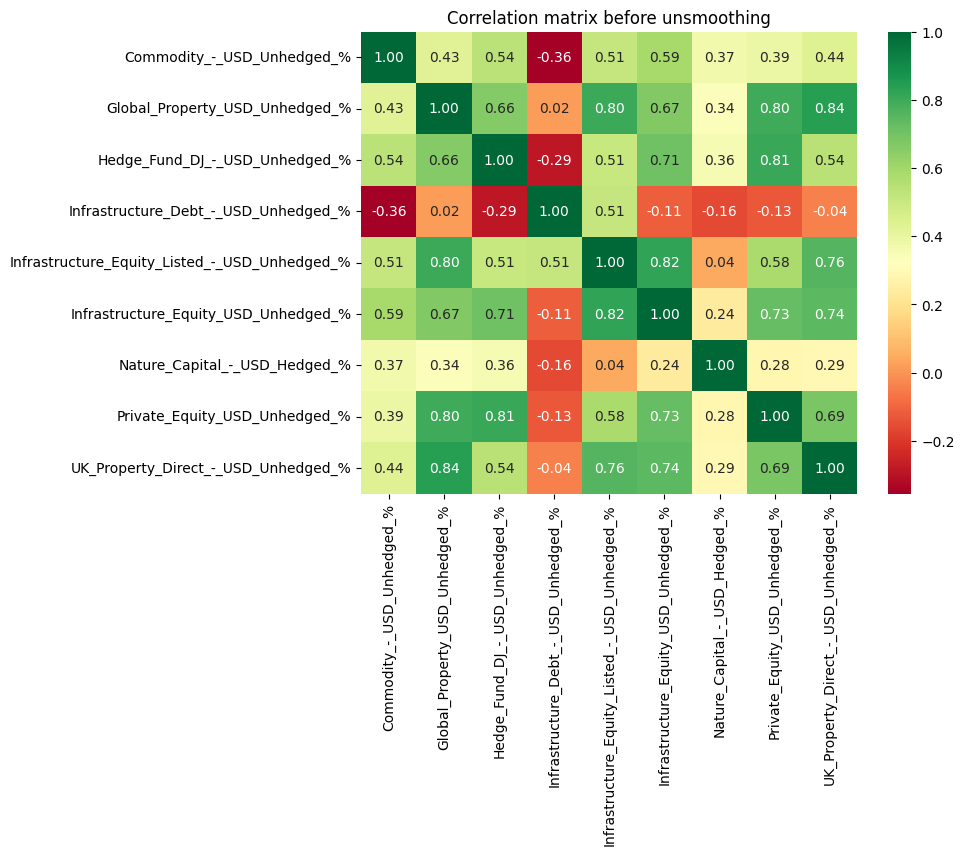

In [27]:
plt.figure(figsize=(8, 6))
corr_matrix  = alternative_data[['Commodity_-_USD_Unhedged_%','Global_Property_USD_Unhedged_%','Hedge_Fund_DJ_-_USD_Unhedged_%'
                                 ,'Infrastructure_Debt_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_USD_Unhedged_%'
                                 ,'Nature_Capital_-_USD_Hedged_%','Private_Equity_USD_Unhedged_%','UK_Property_Direct_-_USD_Unhedged_%']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix before unsmoothing')
plt.show()

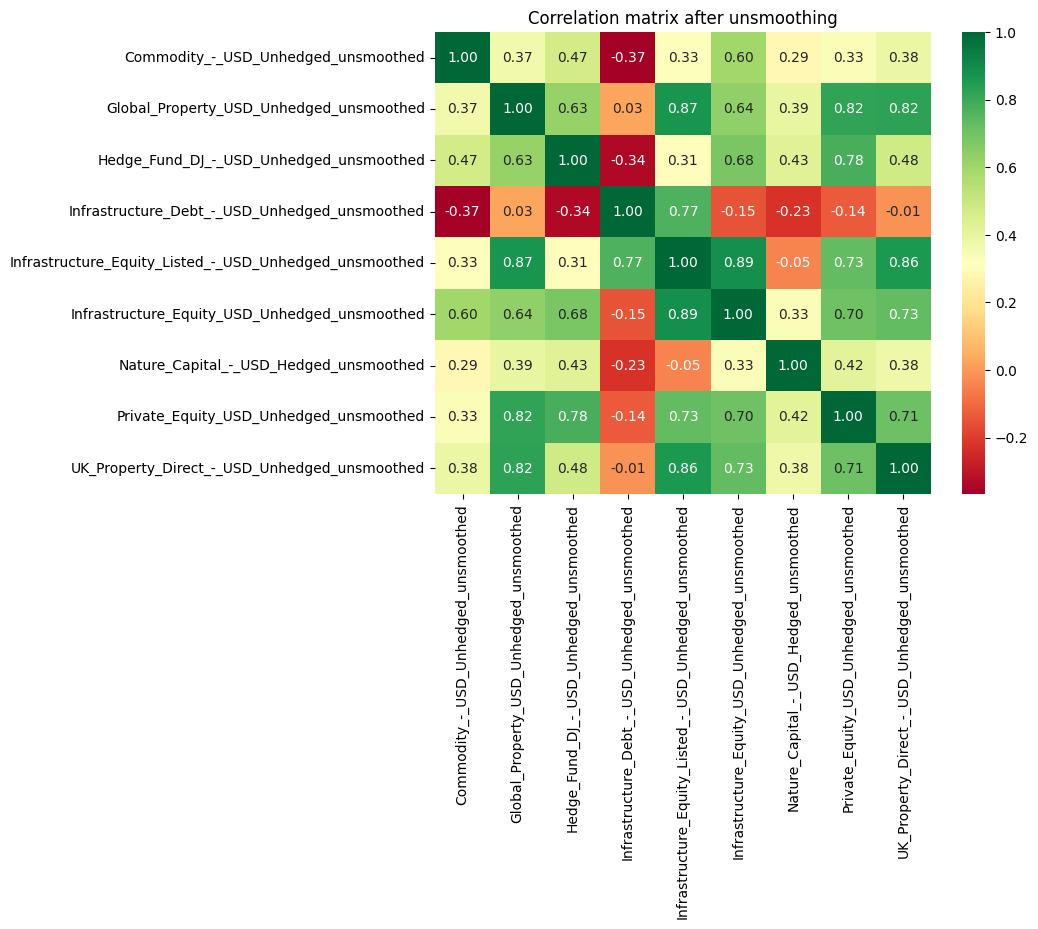

In [28]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix after unsmoothing')
plt.show()

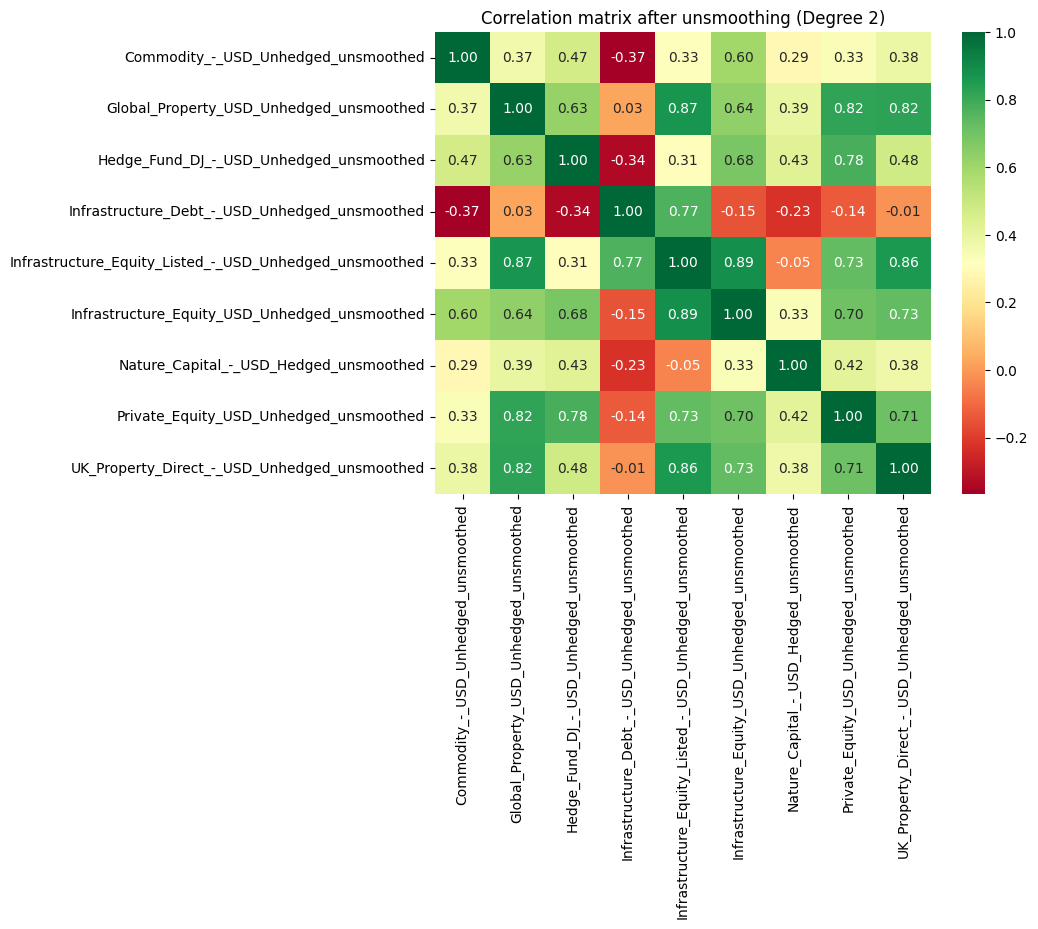

In [29]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation matrix after unsmoothing (Degree 2)')
plt.show()

## Alternative: Linear interpolation
###  Applying linear interpolation:

In [30]:
def data_unsmoothing_linear(df_):
    new = df_.resample('MS').interpolate(method='linear').pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed_linear = data_unsmoothing_linear(alternative_data.iloc[:,0:9])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Text(0.5, 1.0, 'Year 2018 interpolation')

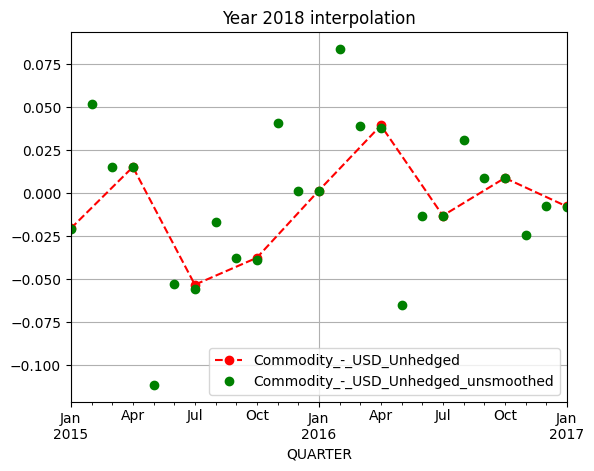

In [31]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

axis.set_title('Year 2018 interpolation')

In [32]:
unsmoothed_linear["Global_Property_USD_Unhedged"]

QUARTER
1993-10-01         NaN
1993-11-01         NaN
1993-12-01         NaN
1994-01-01         NaN
1994-02-01         NaN
                ...   
2023-03-01    0.001806
2023-04-01    0.001803
2023-05-01   -0.004701
2023-06-01   -0.004723
2023-07-01   -0.004745
Freq: MS, Name: Global_Property_USD_Unhedged, Length: 358, dtype: float64

Text(0.5, 1.0, 'Year 2018 interpolation: Linear vs Quadratic')

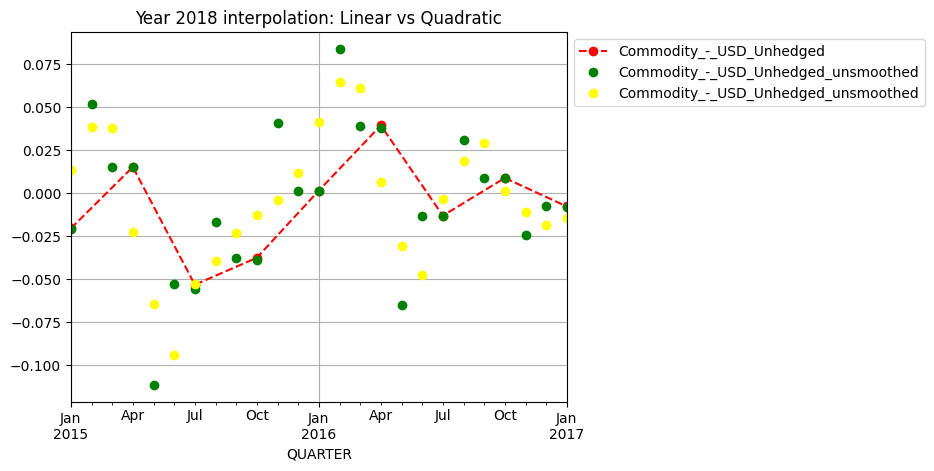

In [33]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend(bbox_to_anchor = (1,1)))

axis.set_title('Year 2018 interpolation: Linear vs Quadratic')

### Correlation matrix for Linear desmoothing

In [34]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed_linear[[col for col in unsmoothed_linear.columns if "unsmoothed" in col]].corr()
(corr_matrix.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
.to_latex("Correlation_matrix_after_unsmoothing_linear.tex"))
# sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
# plt.title('Correlation matrix after unsmoothing (linear)')
# plt.show()

# (pd.DataFrame({name: df[name].dropna()
# for name in alternative_asset_data.columns if "%" in name})
# .resample("QE")
# .last()
# .corr()
# .dropna(how='all', axis = 0)
# .dropna(how='all', axis = 1)
# .style
# .format(precision = 2)
# .background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
# .to_latex('base.tex'))

<Figure size 800x600 with 0 Axes>

### Rolling window (Eh bah non)

In [35]:
# def data_unsmoothing(df_):
#     new = df_.resample('MS').interpolate(method='polynomial', order = 2)
#     for col in df_.columns:
#         new[col + '_unsmoothed'] = new[col].rolling(window = 5).apply(lambda x: AR_model(x.to_numpy()))
#     return new


# unsmoothed = data_unsmoothing(alternative_data.iloc[:,10:])
# unsmoothed.tail(15)

## **III. Getmansky, Lo, Makarov Model**

In [36]:
from web_app.apps.Models.getmansky.GetmanskyMain import GetmanskyModel

In [37]:
alternative_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Alternative Asset", index_col=0)
)

def tweak_data(df_):
    return (df_
            .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns})
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ["Infrastructure_Equity_Listed_-_USD_Unhedged", "Infrastructure_Equity_Listed_-_USD_Unhedged_%"])
        )

alternative_asset_data = tweak_data(alternative_asset_data)[1:]
alternative_asset_data

Commodity_-_USD_Unhedged  Global_Property_USD_Unhedged  \
QUARTER                                                           
1994-Q1                       NaN                           NaN   
1994-Q2                       NaN                           NaN   
1994-Q3                       NaN                           NaN   
1994-Q4                       NaN                           NaN   
1995-Q1                       NaN                           NaN   
...                           ...                           ...   
2022-Q3                  240.5519                   4817.520307   
2022-Q4                  245.8892                   5159.896609   
2023-Q1                  232.7065                   5213.347074   
2023-Q2                  226.7436                   5241.647937   
2023-Q3                  235.6700                   5167.731061   

         Hedge_Fund_DJ_-_USD_Unhedged  Infrastructure_Debt_-_USD_Unhedged  \
QUARTER                                                                     
1994-Q1                           NaN                                 NaN   
1994-Q2                           NaN                                 NaN   
1994-Q3                           NaN                                 NaN   
1994-Q4                           NaN                                 NaN   
1995-Q1                           NaN                                 NaN   
...                               ...                                 ...   
2022-Q3                        727.68                             2122.80   
2022-Q4                        733.63                             2173.62   
2023-Q1                        735.54                             2241.04   
2023-Q2                        748.09                             2248.24   
2023-Q3                        757.82                             2255.04   

         Infrastructure_Equity_USD_Unhedged  Nature_Capital_-_USD_Hedged  \
QUARTER                                                                    
1994-Q1                                 NaN                          NaN   
1994-Q2                                 NaN                          NaN   
1994-Q3                                 NaN                          NaN   
1994-Q4                                 NaN                          NaN   
1995-Q1                                 NaN                          NaN   
...                                     ...                          ...   
2022-Q3                          226.816903                  1960.578024   
2022-Q4                          258.409265                  2023.095816   
2023-Q1                          250.338364                  2026.152916   
2023-Q2                          241.619726                          NaN   
2023-Q3                          243.881391                          NaN   

         Private_Equity_USD_Unhedged  UK_Property_Direct_-_USD_Unhedged  \
QUARTER                                                                   
1994-Q1                      389.140                                NaN   
1994-Q2                      400.750                                NaN   
1994-Q3                      415.450                                NaN   
1994-Q4                      416.120                                NaN   
1995-Q1                      438.950                                NaN   
...                              ...                                ...   
2022-Q3                     3274.373                         187.833995   
2022-Q4                     3719.178                         210.098219   
2023-Q1                     3976.480                         214.263907   
2023-Q2                     4311.668                         211.147599   
2023-Q3                     4389.205                         224.439503   

         Commodity_-_USD_Unhedged_%  Global_Property_USD_Unhedged_%  \
QUARTER                                                               
1994-Q1                     

In [38]:
classic_asset_data = (
    # Importing the dataset
    pd.read_excel("/Users/adamelbernoussi/Desktop/EnsaeAlternativeSubject/EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Classic Asset", index_col=1)
)

def tweak_data(df_):
    return (
        df_
        .resample('ME')
        .last()
        .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns if df_[col].dtype != object})
        .rename(lambda c: c.replace(' ','_'), axis = 1)
        .reset_index()
        .assign(QUARTER=lambda x: x["QUARTER"].bfill()) #only one value is missing in the dataframe
        .set_index("QUARTER")        
    )

classic_asset_data = tweak_data(classic_asset_data)[1:]
classic_asset_data

Date  Liquidity_USD_Unhedged  US_Equity_USD_Unhedged  \
QUARTER                                                              
1998-Q1 1998-03-31              146.135886             3099.360000   
1998-Q2 1998-04-30              146.872656             3136.193000   
1998-Q2 1998-05-31              147.551539             3073.750000   
1998-Q2 1998-06-30              148.232494             3206.355000   
1998-Q3 1998-07-31              149.008144             3175.110000   
...            ...                     ...                     ...   
2023-Q2 2023-04-30              118.444827            18414.905335   
2023-Q2 2023-05-31              118.990836            18534.693812   
2023-Q2 2023-06-30              119.497744            19770.619413   
2023-Q3 2023-07-31              120.032429            20451.176585   
2023-Q3 2023-08-31              120.416750            19537.023755   

         US_Government_Bond_USD_Unhedged  USD_Corporate_Bond_-_USD_Unhedged  \
QUARTER                                                                       
1998-Q1                       242.190000                         952.750061   
1998-Q2                       243.270000                         958.766296   
1998-Q2                       245.790000                         970.149414   
1998-Q2                       248.630000                         977.322327   
1998-Q3                       249.020000                         976.397705   
...                                  ...                                ...   
2023-Q2                       604.922865                        3095.666047   
2023-Q2                       597.900543                        3050.833843   
2023-Q2                       593.410756                        3063.387009   
2023-Q3                       591.308947                        3073.953154   
2023-Q3                       580.271813                        2992.667990   

         Liquidity_USD_Unhedged_%  US_Equity_USD_Unhedged_%  \
QUARTER                                                       
1998-Q1                  0.004613                  0.052027   
1998-Q2                  0.005042                  0.011884   
1998-Q2                  0.004622                 -0.019910   
1998-Q2                  0.004615                  0.043141   
1998-Q3                  0.005233                 -0.009745   
...                           ...                       ...   
2023-Q2                       NaN                       NaN   
2023-Q2                  0.000143                 -0.005608   
2023-Q2                  0.000142                  0.012186   
2023-Q3                  0.000436                  0.002027   
2023-Q3                       NaN                       NaN   

         US_Government_Bond_USD_Unhedged_%  \
QUARTER                                      
1998-Q1                           0.002733   
1998-Q2                           0.004459   
1998-Q2                           0.010359   
1998-Q2                           0.011555   
1998-Q3                           0.001569   
...                                    ...   
2023-Q2                                NaN   
2023-Q2                           0.003326   
2023-Q2                           0.002510   
2023-Q3                           0.001179   
2023-Q3                                NaN   

         USD_Corporate_Bond_-_USD_Unhedged_%  
QUARTER                                       
1998-Q1                             0.003693  
1998-Q2                             0.006315  
1998-Q2                             0.011873  
1998-Q2                             0.007394  
1998-Q3                            -0.000946  
...                                      ...  
2023-Q2                                  NaN  
2023-Q2                             0.002719  
2023-Q2                             0.005197  
2023-Q3                             0.002296  
2023-Q3                                  NaN  

[306 rows x 9 columns]

In [39]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    #.loc[start_date:end_date]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1)
        )
    index = df[col].dropna().index
    if len(index)>1:
        bench = df.loc[index, benchmark]
        # bench.plot(label = "Bench")
        # df[col].dropna().plot(label = col)
        # plt.legend()
        # plt.show()
        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
        )
        df[col+'_unsmoothed'] = np.nan
        try:
            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=None)
            # if you want to rebase add rebase=df[col].dropna().values as a parameter of the function
        except ValueError:
            pass
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0

#switching to improve readability
if window is None: window = 0


# rebasing
df = (
    df
    .assign(**{
        col: df[col].iloc[len(df[col])-df[col].count()+window:]
        for col in alternative_asset_data.columns if "%" in col
    })    
    .pipe(lambda df_temp : df_temp.assign(**{
        col: df_temp[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns
    }))
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%" in col
    }))
    .pipe(lambda df_temp : df_temp.assign(**{
        col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
            [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns if "%" in col
    }))
)

In [40]:
print("volatilité annualisé :")
volatility = pd.DataFrame({"volatilité" : [df[name].resample("QE").last().dropna().std()*np.sqrt(4)
for name in alternative_asset_data.columns if "%" in name]}, index = [name for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé :


volatilité
Commodity_-_USD_Unhedged_%              0.179158
Global_Property_USD_Unhedged_%          0.196396
Hedge_Fund_DJ_-_USD_Unhedged_%          0.070764
Infrastructure_Debt_-_USD_Unhedged_%    0.049742
Infrastructure_Equity_USD_Unhedged_%    0.154062
Nature_Capital_-_USD_Hedged_%           0.149982
Private_Equity_USD_Unhedged_%           0.316194
UK_Property_Direct_-_USD_Unhedged_%     0.187545

In [41]:
print("volatilité annualisé unsmoothed No rolling no rebase:")
volatility = pd.DataFrame({"volatilité" : [df[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé unsmoothed No rolling no rebase:


volatilité
Commodity_-_USD_Unhedged_%_unsmoothed              0.053796
Global_Property_USD_Unhedged_%_unsmoothed          0.134351
Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed          0.043529
Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed    0.011005
Infrastructure_Equity_USD_Unhedged_%_unsmoothed    0.081489
Nature_Capital_-_USD_Hedged_%_unsmoothed           0.041321
Private_Equity_USD_Unhedged_%_unsmoothed           0.238478
UK_Property_Direct_-_USD_Unhedged_%_unsmoothed     0.102706

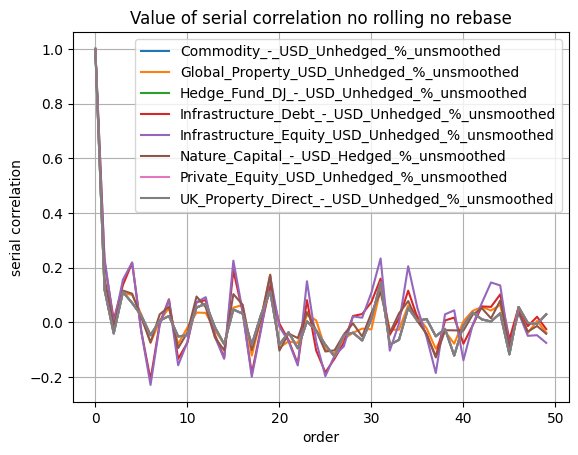

In [42]:
serial_correlation = pd.DataFrame({name+"_unsmoothed":[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation no rolling no rebase' )
.legend(bbox_to_anchor = (1,1)))

warnings.filterwarnings('ignore', category=RuntimeWarning)

plt.show()

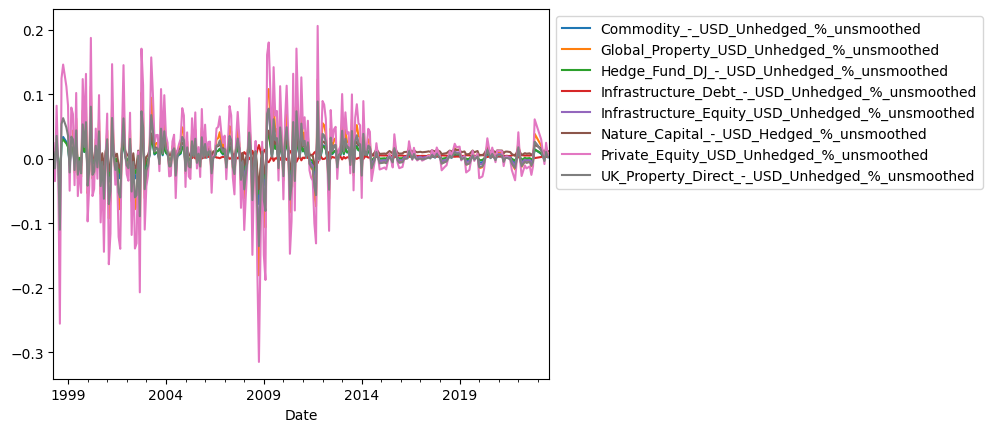

In [43]:
(df[[col for col in df.columns if "%_unsmoothed" in col and "TR" not in col]].plot()
    .legend(bbox_to_anchor = (1,1)))

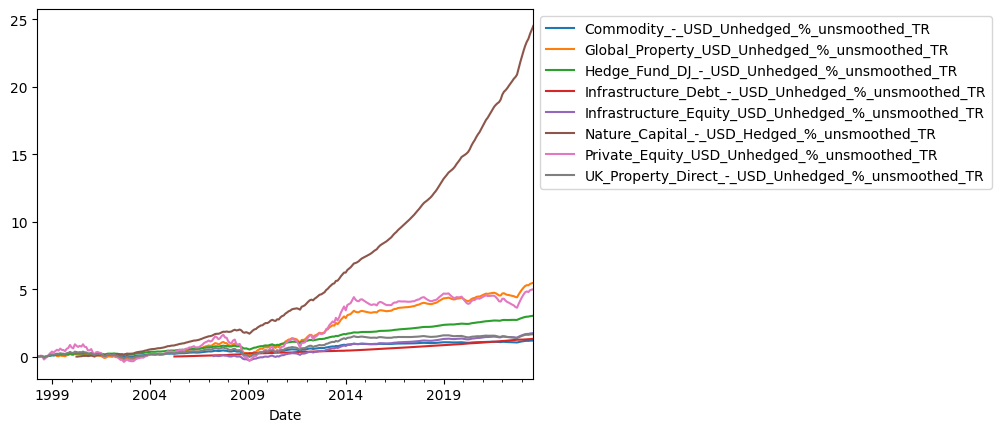

In [44]:
(df[[col for col in df.columns if "%_unsmoothed_TR" in col]].plot()
    .legend(bbox_to_anchor = (1,1)))

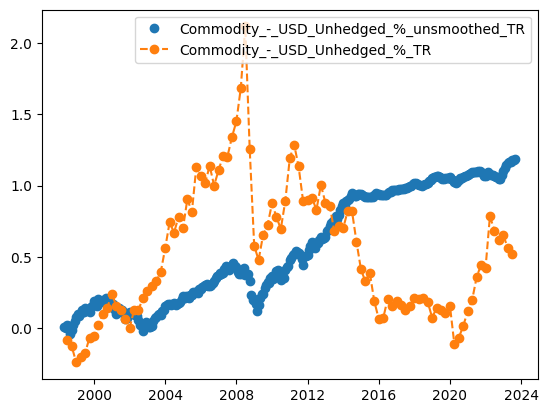

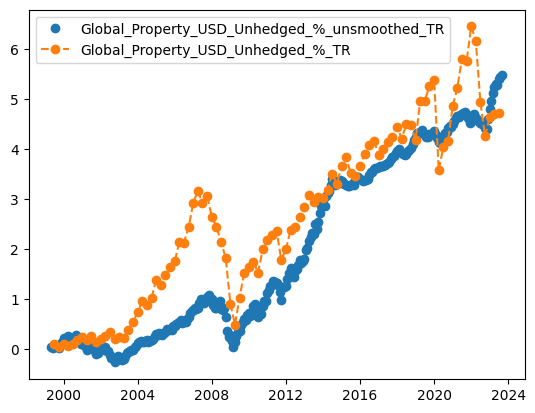

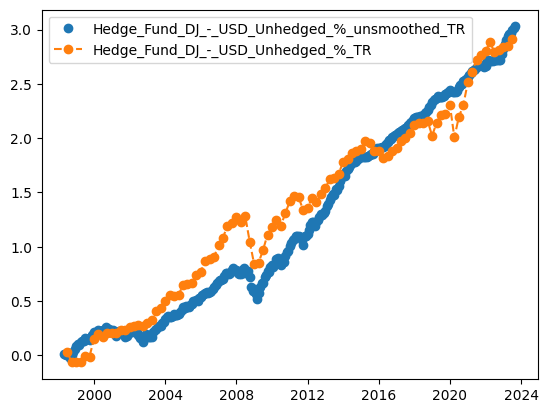

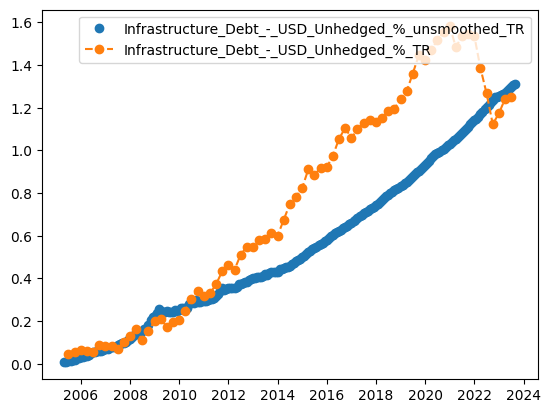

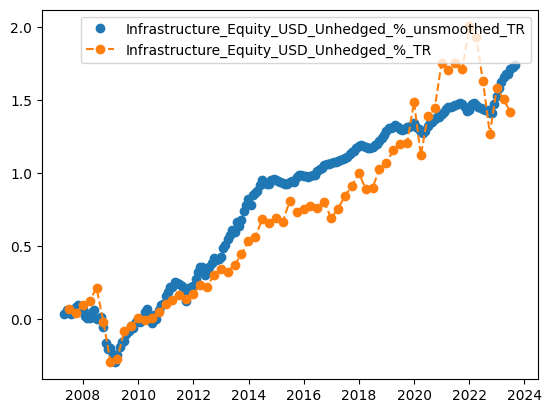

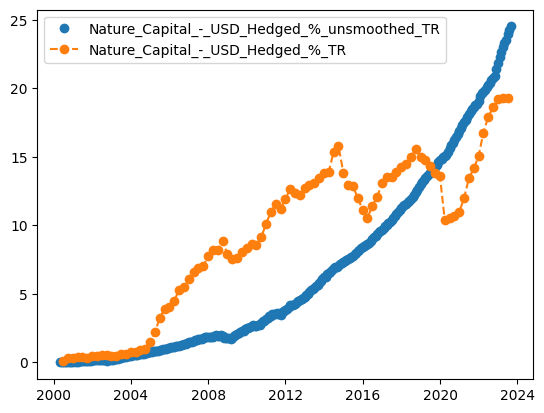

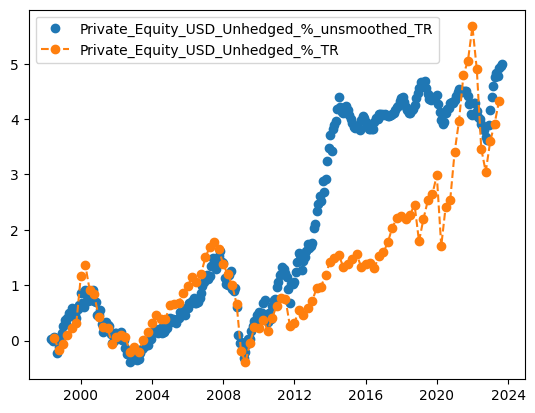

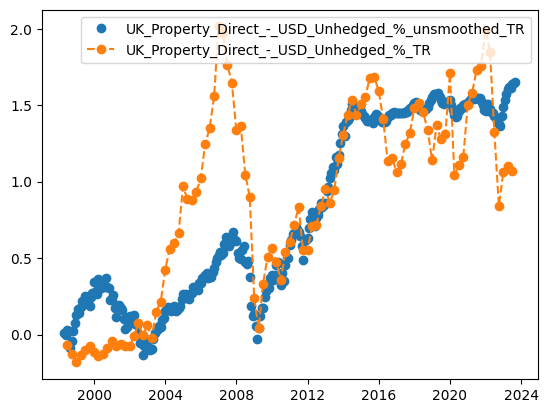

In [45]:
gen = [col for col in df.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df.index, df[col],
        marker = 'o',
        linestyle = '',
        label = col)
    plt.plot(df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"].index, df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"],
        marker = 'o',
        linestyle = '--',
        label = col[:-14]+"_TR")
    plt.legend()
    plt.show()

### Getmansky avec window

In [46]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = 12 # choose an int or put None
benchmark = 'USD_Corporate_Bond_-_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    #.loc[start_date:end_date]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1)
        )
    index = df[col].dropna().index
    if len(index)>1:
        bench = df.loc[index, benchmark]
        # bench.plot(label = "Bench")
        # df[col].dropna().plot(label = col)
        # plt.legend()
        # plt.show()
        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
        )
        df[col+'_unsmoothed'] = np.nan
        try:
            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=df[col].dropna().values)
            # if you want to rebase add rebase=df[col].dropna().values as a parameter of the function
        except ValueError:
            pass
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0

#switching to improve readability
if window is None: window = 0


# rebasing
df = (
    df
    .assign(**{
        col: df[col].iloc[len(df[col])-df[col].count()+window:]
        for col in alternative_asset_data.columns if "%" in col
    })    
    .pipe(lambda df_temp : df_temp.assign(**{
        col: df_temp[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns
    }))
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%" in col
    }))
    .pipe(lambda df_temp : df_temp.assign(**{
        col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
            [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns if "%" in col
    }))
)

In [47]:
df = df.loc["2008":"2012"]

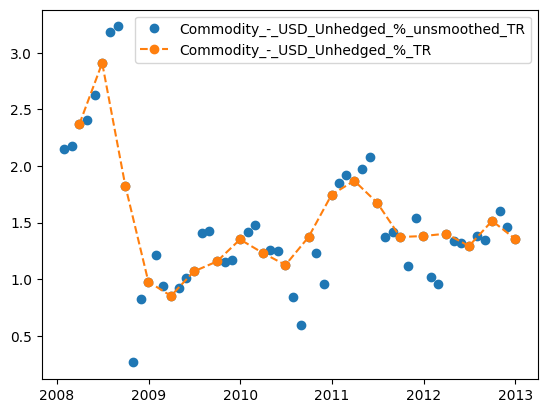

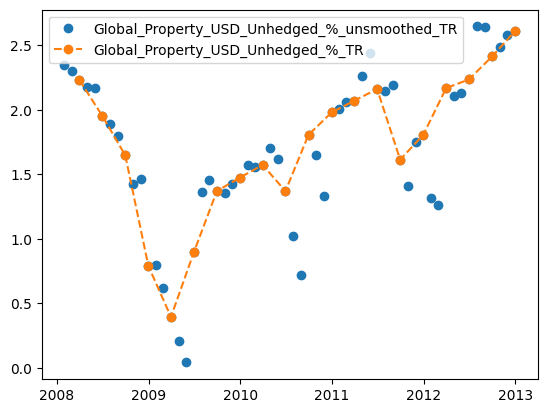

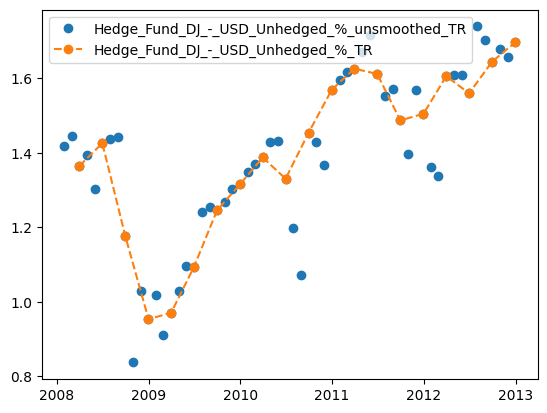

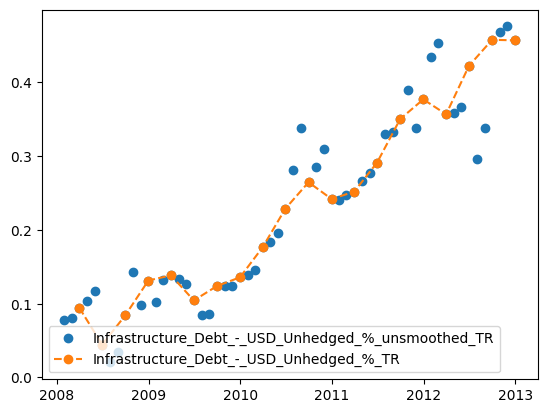

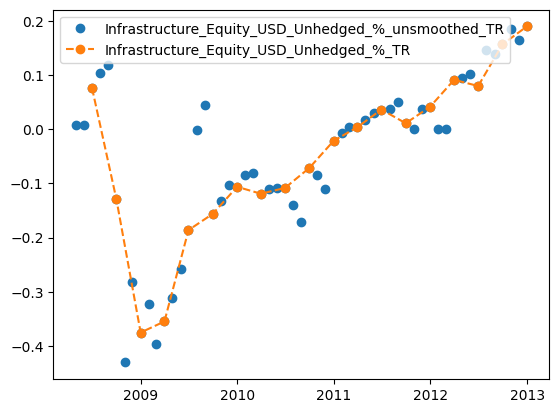

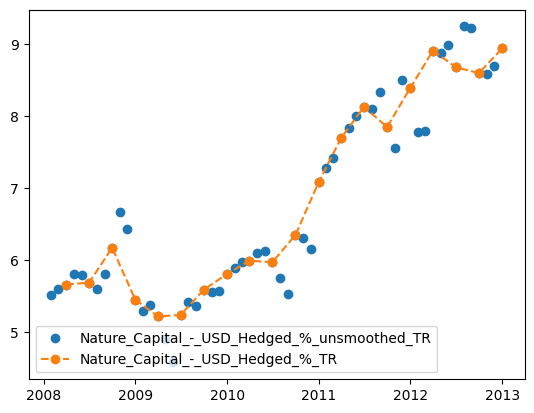

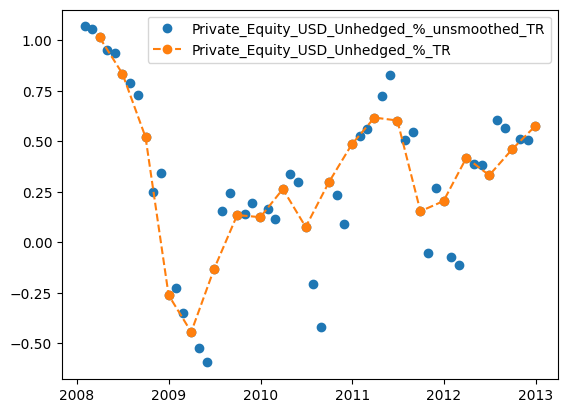

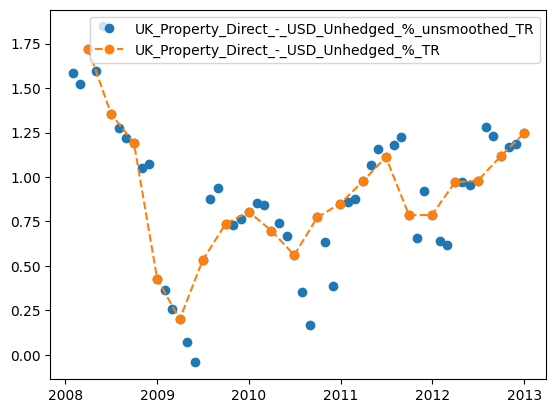

In [48]:
gen = [col for col in df.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df.index, df[col],
        marker = 'o',
        linestyle = '',
        label = col)
    plt.plot(df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"].index, df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"],
        marker = 'o',
        linestyle = '--',
        label = col[:-14]+"_TR")
    plt.legend()
    plt.show()

In [49]:
import plotly.express as px

gen = [col for col in df.columns if "%_unsmoothed_TR" in col]
for col in gen:
    fig = px.line(x = df.index, y = df[col], markers = 'o')
    fig.add_scatter(x = df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"].index, y = df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"])
    fig.show()

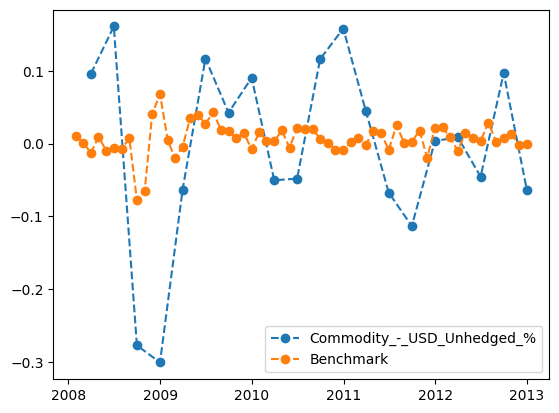

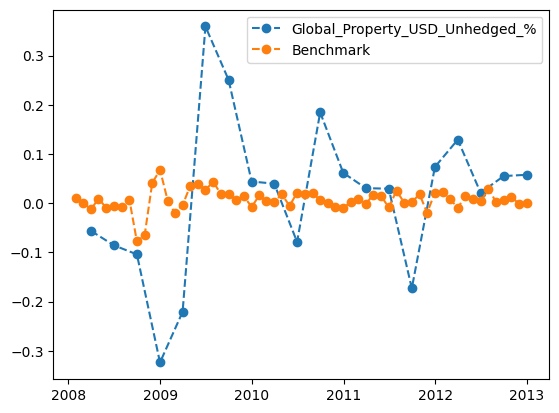

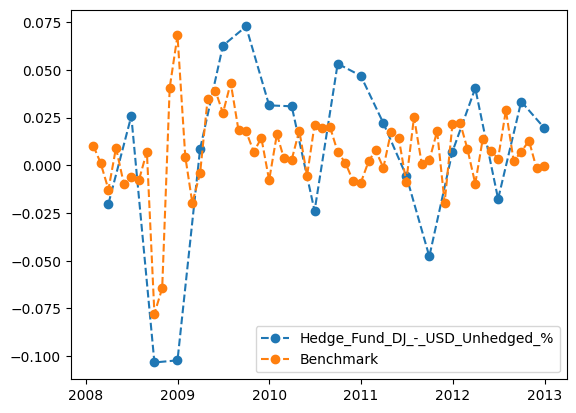

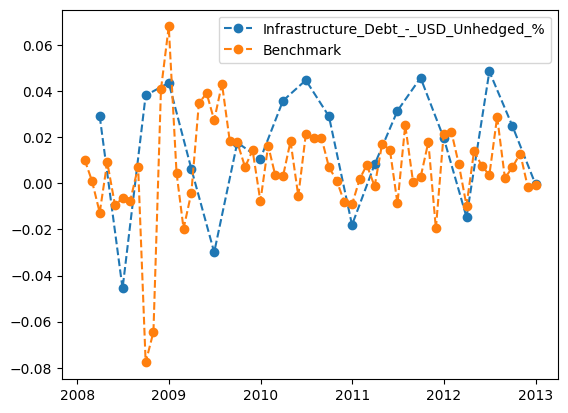

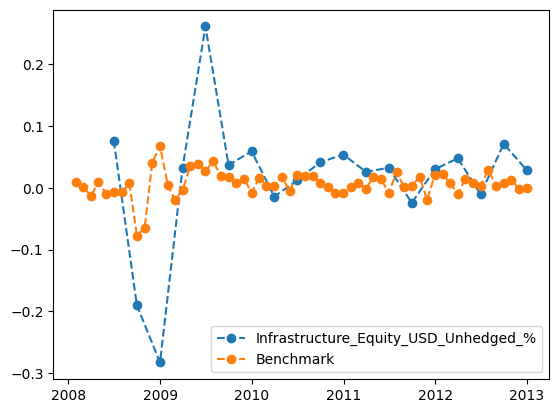

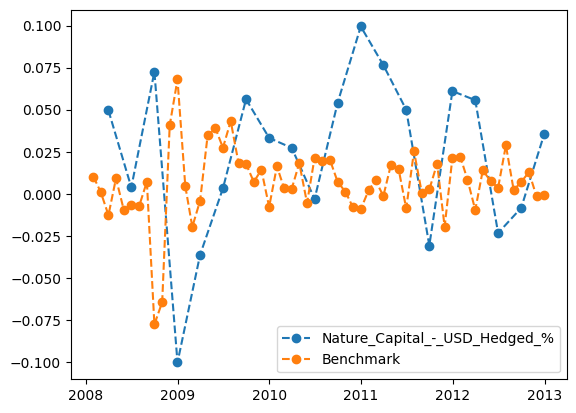

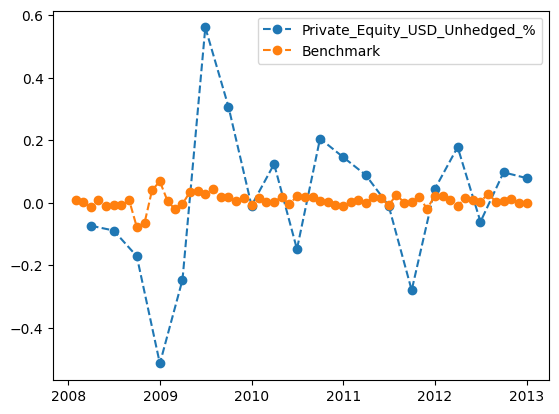

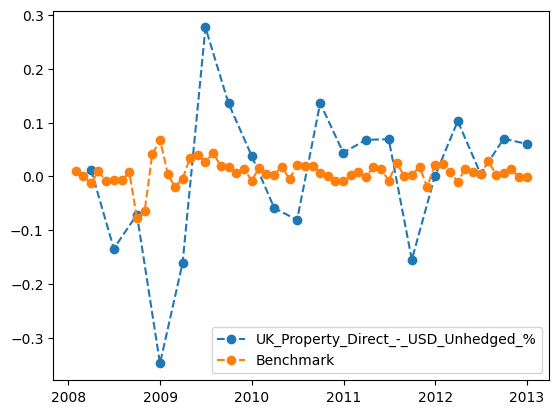

In [50]:
gen = [col for col in df.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]].index, df.loc[df.index.month.isin([3, 6, 9, 12]), col[:-14]],
        marker = 'o',
        linestyle = '--',
        label = col[:-14])
    plt.plot(df.index, df[benchmark],
        marker = 'o',
        linestyle = '--',
        label = "Benchmark")
    plt.legend()
    plt.show()

In [51]:
print("volatilité annualisé :")
volatility = pd.DataFrame({"volatilité" : [df[name].resample("QE").last().dropna().std()*np.sqrt(4)
for name in alternative_asset_data.columns if "%" in name]}, index = [name for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé :


volatilité
Commodity_-_USD_Unhedged_%              0.254358
Global_Property_USD_Unhedged_%          0.314767
Hedge_Fund_DJ_-_USD_Unhedged_%          0.096647
Infrastructure_Debt_-_USD_Unhedged_%    0.053382
Infrastructure_Equity_USD_Unhedged_%    0.215250
Nature_Capital_-_USD_Hedged_%           0.095844
Private_Equity_USD_Unhedged_%           0.462291
UK_Property_Direct_-_USD_Unhedged_%     0.271115

In [52]:
print("volatilité annualisé unsmoothed rolling and rebased:")
volatility = pd.DataFrame({"volatilité" : [df[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé unsmoothed rolling and rebased:


volatilité
Commodity_-_USD_Unhedged_%_unsmoothed              0.525613
Global_Property_USD_Unhedged_%_unsmoothed          0.593246
Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed          0.175489
Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed    0.106928
Infrastructure_Equity_USD_Unhedged_%_unsmoothed    0.308042
Nature_Capital_-_USD_Hedged_%_unsmoothed           0.165199
Private_Equity_USD_Unhedged_%_unsmoothed           0.941037
UK_Property_Direct_-_USD_Unhedged_%_unsmoothed     0.500166

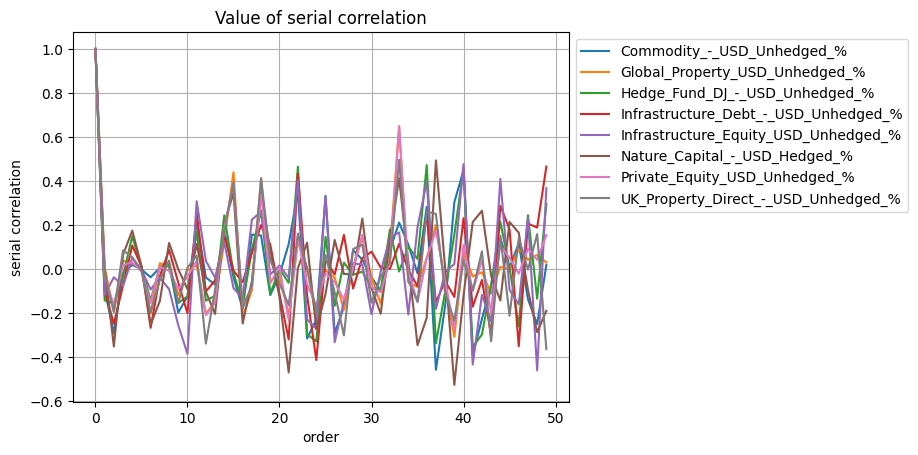

In [53]:
serial_correlation = pd.DataFrame({name:[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

warnings.filterwarnings('ignore', category=RuntimeWarning)

plt.show()

### Délire de la correlation

In [54]:
(pd.DataFrame({name: df[name].dropna()
for name in alternative_asset_data.columns if "%" in name})
.resample("QE")
.last()
.corr()
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex('base.tex')
)

In [55]:
(pd.DataFrame({name+"_unsmoothed": df[name+"_unsmoothed"].dropna()
for name in alternative_asset_data.columns if "%" in name})
.resample("QE")
.last()
.corr()
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex("autocorrel_unsmoothed_getmansky.tex")
)

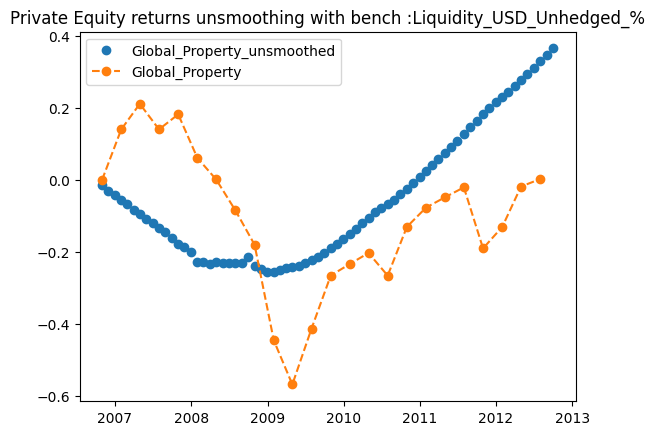

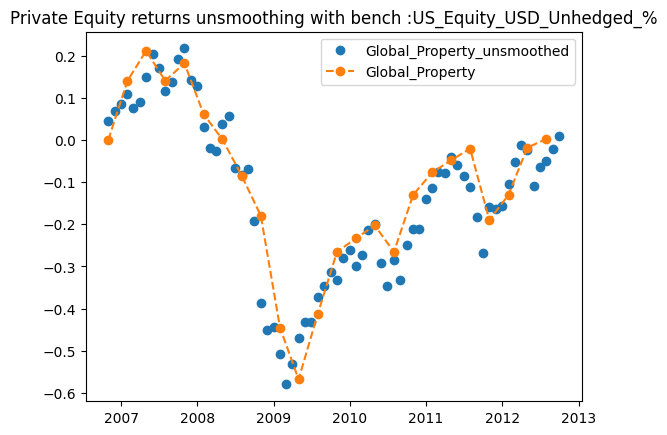

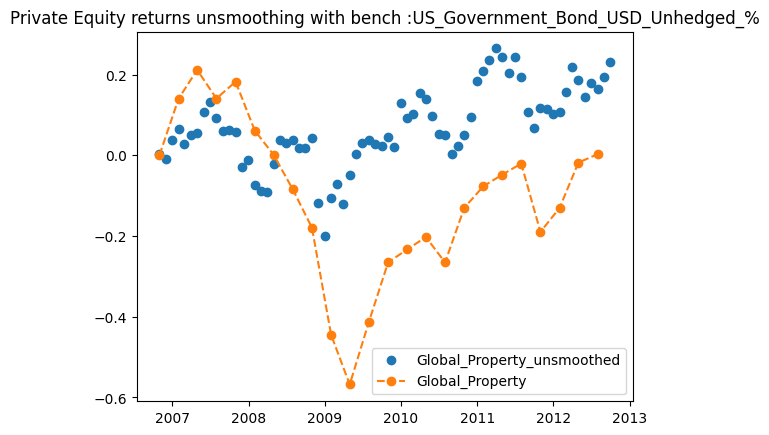

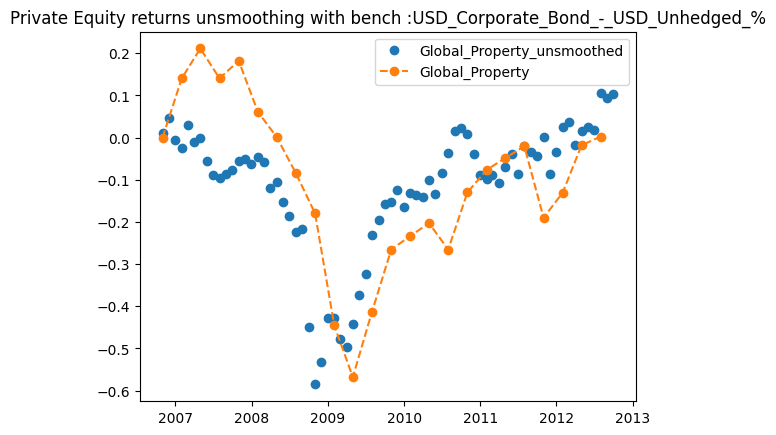

In [56]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'

for benchmark in ['Liquidity_USD_Unhedged_%', 
                  'US_Equity_USD_Unhedged_%',
                  'US_Government_Bond_USD_Unhedged_%',
                  'USD_Corporate_Bond_-_USD_Unhedged_%']:
    df = (
        classic_asset_data
        .copy()
        .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
        .set_index("Date")
        .loc[start_date:end_date]
        .iloc[1:]
    )

    #deal with potential missing values
    if df.isna().any().any():
        df.interpolate(method='linear', inplace=True)

    for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
        getmansky = GetmanskyModel(order)

        if weight_type != "optimized":
            getmansky.set_default_weights(weight_type)
        else:
            getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                    df[col].values.reshape(-1,1)
                    )
        index = df[col].dropna().index
        if len(index)>3:
            bench = df.loc[index, benchmark]

            getmansky.fit(bench.values.reshape(-1, 1), 
                        df[col].dropna().values.reshape(-1,1), 
                        window = window
            )

            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
            # if you want to rebase add rebase=df[col].dropna().values as a parameter of the function
        else:
            warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
            df[col+'_unsmoothed'] = 0


    df = (
        df
        .assign(**{
            col: df[col].mul(pd.Series(
                [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
                index = df[col].index
                )) 
            for col in alternative_asset_data.columns
        })
        .pipe(lambda df_temp: df_temp.assign(**{
            col + '_TR': (df_temp[col]+1).cumprod()-1
            for col in df_temp.columns if "%" in col
        }))
    )



    fig, axes = plt.subplots()

    plt.title("Private Equity returns unsmoothing with bench :" + benchmark)

    plt.plot(df.index, df["Global_Property_USD_Unhedged_%_unsmoothed_TR"],
            marker = 'o',
            linestyle = '',
            label = "Global_Property_unsmoothed")
    plt.plot(df.index[::3], df['Global_Property_USD_Unhedged_%_TR'].iloc[::3],
            marker = 'o',
            linestyle = '--',
            label = "Global_Property")

    plt.legend()
    plt.show()
            

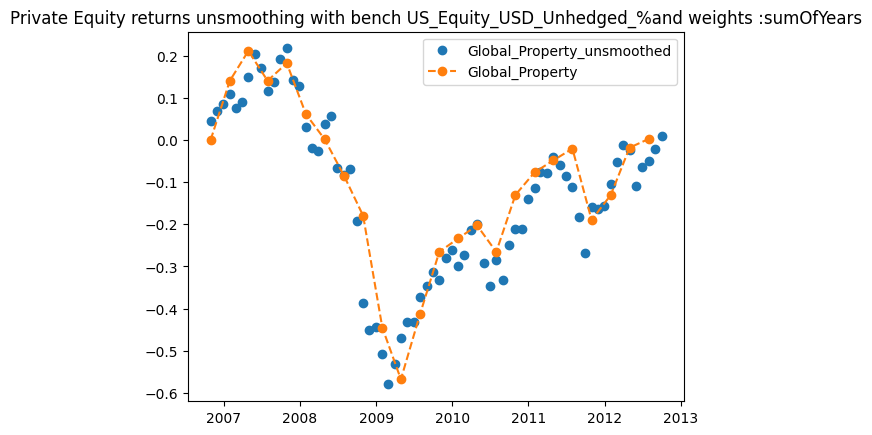

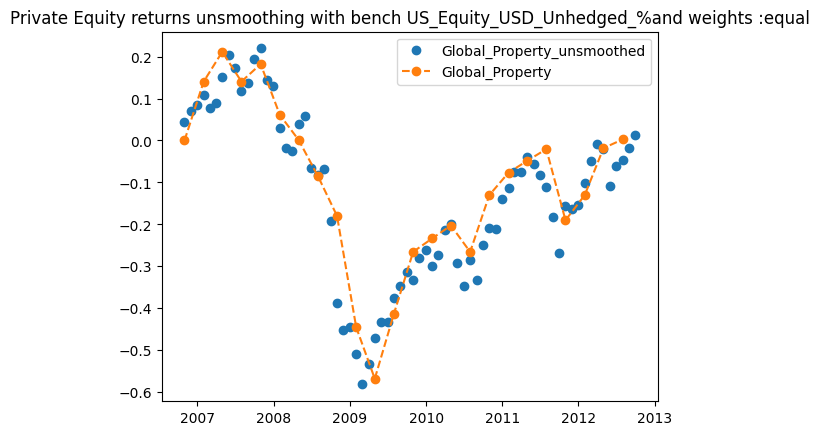

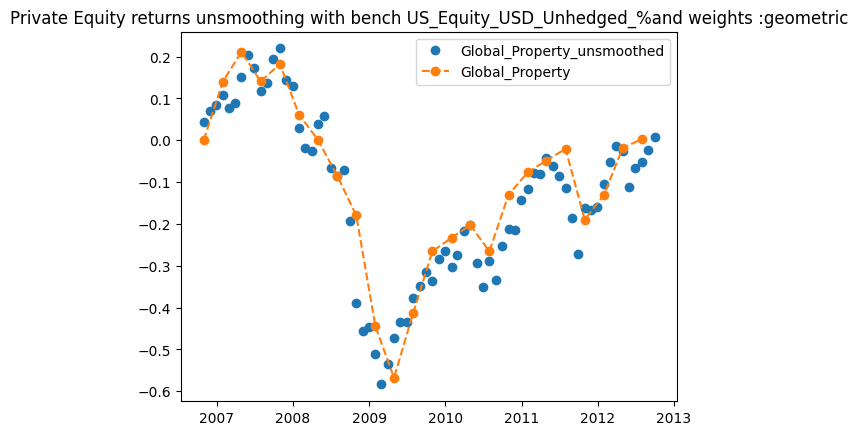

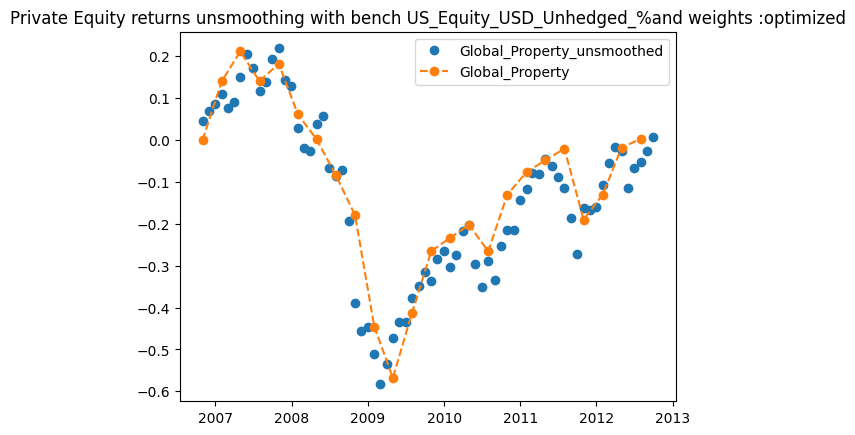

In [57]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'
warnings.filterwarnings('ignore', category=FutureWarning)

for weight_type in ["sumOfYears", "equal", "geometric", "optimized"]:
    df = (
        classic_asset_data
        .copy()
        .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
        .set_index("Date")
        .loc[start_date:end_date]
        .iloc[1:]
    )

    #deal with potential missing values
    if df.isna().any().any():
        df.interpolate(method='linear', inplace=True)

    for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
        getmansky = GetmanskyModel(order)
        if weight_type != "optimized":
            getmansky.set_default_weights(weight_type, delta = 0.9)
        elif np.isnan(df[col].values).sum()==0:
            getmansky.optimize_weights_LR(df[benchmark].values, 
                    df[col].values
                )
        else:
            df[col+'_unsmoothed'] = 0
        index = df[col].dropna().index
        if len(index)>3:
            bench = df.loc[index, benchmark]

            getmansky.fit(bench.values.reshape(-1, 1), 
                        df[col].dropna().values.reshape(-1,1), 
                        window = window
                        )
            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
            # if you want to rebase add rebase=df[col].dropna().values as a parameter of the function
        else:
            warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
            df[col+'_unsmoothed'] = 0


    df = (
        df
        .assign(**{
            col: df[col].mul(pd.Series(
                [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
                index = df[col].index
                )) 
            for col in alternative_asset_data.columns
        })
        .pipe(lambda df_temp: df_temp.assign(**{
            col + '_TR': (df_temp[col]+1).cumprod()-1
            for col in df_temp.columns if "%" in col
        }))
    )



    fig, axes = plt.subplots()

    plt.title("Private Equity returns unsmoothing with bench " + benchmark + "and weights :" +weight_type)

    plt.plot(df.index, df["Global_Property_USD_Unhedged_%_unsmoothed_TR"],
            marker = 'o',
            linestyle = '',
            label = "Global_Property_unsmoothed")
    plt.plot(df.index[::3], df['Global_Property_USD_Unhedged_%_TR'].iloc[::3],
            marker = 'o',
            linestyle = '--',
            label = "Global_Property")

    plt.legend()
    plt.show()

